In [1]:
# dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
import keras_tuner
from sklearn.metrics import classification_report
import os
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import time

2025-10-09 03:40:21.631352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-09 03:40:21.758238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-09 03:40:21.798208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-09 03:40:21.994434: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_path = "datasets/products.csv"
df = pd.read_csv(file_path)

In [3]:
df = df.dropna(subset = ["image_url", "brand"])
df = df[["image_url", "brand", "path"]]
min_count = 200
brand_counts = df["brand"].value_counts()

# keep only brands with >= 200 samples
df = df[df["brand"].isin(brand_counts[brand_counts >= min_count].index)]

# cast the classes into integers
label_encoder = LabelEncoder()
df["brand"] = label_encoder.fit_transform(df["brand"])
df["brand"] = df["brand"].astype(np.int32)

train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42)


In [4]:
# prepare the data
IMG_DIR = "images"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def fetch_images(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3) # since every pixel has values [0, 255], dividing by 255 normalizes them to [0, 1]
    img = tf.image.resize(img, IMG_SIZE ) / 255.0

    return tf.cast(img, tf.float32), tf.cast(label, tf.int32)

def tf_fetch_image(url, label):

    img, lbl = tf.py_function(fetch_images, [url, label], [tf.float32, tf.int32])
    img.set_shape((*IMG_SIZE, 3))
    lbl.set_shape(())

    return img, lbl

def make_datasets(sub_dataframe):
    paths = [os.path.join(IMG_DIR, f"{name}.jpg") for name in sub_dataframe["path"]]

    ds = tf.data.Dataset.from_tensor_slices((paths, sub_dataframe["brand"].values))
    ds = ds.map(tf_fetch_image, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds, val_ds, test_ds = make_datasets(train_df), make_datasets(val_df), make_datasets(test_df)




I0000 00:00:1759981227.160352  809693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759981227.427117  809693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759981227.427215  809693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759981227.431886  809693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759981227.431956  809693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

(32, 128, 128, 3) tf.Tensor([0 0 3 4 4 7 0 4 0 5 4 0 0 2 0 2 0 4 7 5 0 3 4 6 0 7 0 6 1 1 7 7], shape=(32,), dtype=int32)


2025-10-09 03:40:28.149699: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


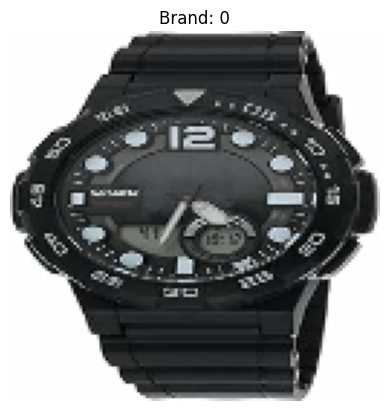

2025-10-09 03:40:28.327644: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# here we can visualize the data (optional)

"""
the first for loop displays:

(32, 224, 224, 3) [3.3, ...., 1.5]

Here we have:
- a batch of 32 images
- 224x224 each (and their 3 respetive channels)
- [ints] the array of brands for each image
"""

for img, lbl in train_ds.take(1):
    print(img.shape, lbl)

"""
second for loop shows the image
"""
for imgs, labels in train_ds.take(1):
    plt.imshow(imgs[0])        # show first image in the batch
    plt.title(f"Brand: {labels[0].numpy()}")
    plt.axis("off")
    plt.show()


In [6]:
def build_cnn_model(hp):
    num_classes = 8
    model = tf.keras.Sequential()

    # input layer
    model.add(tf.keras.layers.Input(shape = (128, 128, 3)))

    # convolutional layers
    for i in range(hp.Int("num_conv_layers", 3, 4)):
        model.add(tf.keras.layers.Conv2D(
            filters = hp.Int(f"filters_{i}", min_value = 32, max_value = 128, step = 32),
            kernel_size = hp.Choice("kernel_size", values = [3]),
            activation = "relu",
            padding = "same"
        ))
        model.add(tf.keras.layers.Dropout(
        rate=hp.Float(f"dropout_conv_{i}", min_value=0.1, max_value=0.4, step=0.1)
            ))
        model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))


    # global average pooling to connect with dense layers
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # dense layers

    model.add(tf.keras.layers.Dense(
        units = hp.Int(f"units_dense_1", min_value = 64, max_value = 128, step = 64),
        activation = hp.Choice("activation", ["relu"])
    ))

    # dropout after dense layers
    model.add(tf.keras.layers.Dropout(
      rate = 0.5
    ))

    # output layer for classification
    model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

    # compile for classification
    model.compile(
        optimizer = "adam",
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )

    return model

In [7]:
build_cnn_model(keras_tuner.HyperParameters())

In [8]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_cnn_model,
    objective = "val_accuracy",
    max_trials = 15,
    directory = "my_dir",
    project_name = "cnn_classification_tunning",
    overwrite = True
)

tuner.search_space_summary()

Search space summary
Default search space size: 10
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
dropout_conv_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_conv_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_conv_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 

In [9]:
tuner.search(
    train_ds,
    validation_data = val_ds,
    epochs = 5,
)

Trial 15 Complete [00h 00m 26s]
val_accuracy: 0.44208037853240967

Best val_accuracy So Far: 0.513002336025238
Total elapsed time: 00h 06m 45s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary()

Results summary
Results in my_dir/cnn_classification_tunning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
num_conv_layers: 4
filters_0: 32
kernel_size: 3
dropout_conv_0: 0.4
filters_1: 96
dropout_conv_1: 0.30000000000000004
filters_2: 96
dropout_conv_2: 0.2
units_dense_1: 64
activation: relu
filters_3: 64
dropout_conv_3: 0.4
Score: 0.513002336025238

Trial 06 summary
Hyperparameters:
num_conv_layers: 4
filters_0: 32
kernel_size: 3
dropout_conv_0: 0.30000000000000004
filters_1: 32
dropout_conv_1: 0.2
filters_2: 96
dropout_conv_2: 0.30000000000000004
units_dense_1: 128
activation: relu
filters_3: 128
dropout_conv_3: 0.4
Score: 0.46335697174072266

Trial 00 summary
Hyperparameters:
num_conv_layers: 4
filters_0: 128
kernel_size: 3
dropout_conv_0: 0.30000000000000004
filters_1: 32
dropout_conv_1: 0.1
filters_2: 64
dropout_conv_2: 0.4
units_dense_1: 128
activation: relu
filters_3: 32
dropout_conv_3: 0.1
Score: 0.44208037853240967



In [11]:
# extract the best model
best_model = tuner.get_best_models(num_models = 1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 96)        27744     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 96)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 96)        0         
 g2D)                                                   

Epoch 1/35


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

 5/53 [=>............................] - ETA: 1s - loss: 1.4777 - accuracy: 0.4375

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


53/53 [==============================] - 6s 87ms/step - loss: 1.4723 - accuracy: 0.4692 - val_loss: 1.6172 - val_accuracy: 0.5508
Epoch 2/35
53/53 [==============================] - 5s 90ms/step - loss: 1.4028 - accuracy: 0.5047 - val_loss: 1.5451 - val_accuracy: 0.5556
Epoch 3/35
53/53 [==============================] - 5s 95ms/step - loss: 1.3406 - accuracy: 0.5290 - val_loss: 1.5608 - val_accuracy: 0.5225
Epoch 4/35
53/53 [==============================] - 5s 87ms/step - loss: 1.2773 - accuracy: 0.5544 - val_loss: 1.4964 - val_accuracy: 0.5721
Epoch 5/35
53/53 [==============================] - 5s 88ms/step - loss: 1.2627 - accuracy: 0.5740 - val_loss: 1.4905 - val_accuracy: 0.5201
Epoch 6/35
53/53 [==============================] - 5s 85ms/step - loss: 1.2026 - accuracy: 0.5817 - val_loss: 1.4570 - val_accuracy: 0.5461
Epoch 7/35
53/53 [==============================] - 5s 86ms/step - loss: 1.1698 - accuracy: 0.6030 - val_loss: 1.4307 - val_accuracy: 0.5745
Epoch 8/35
53/53 [======

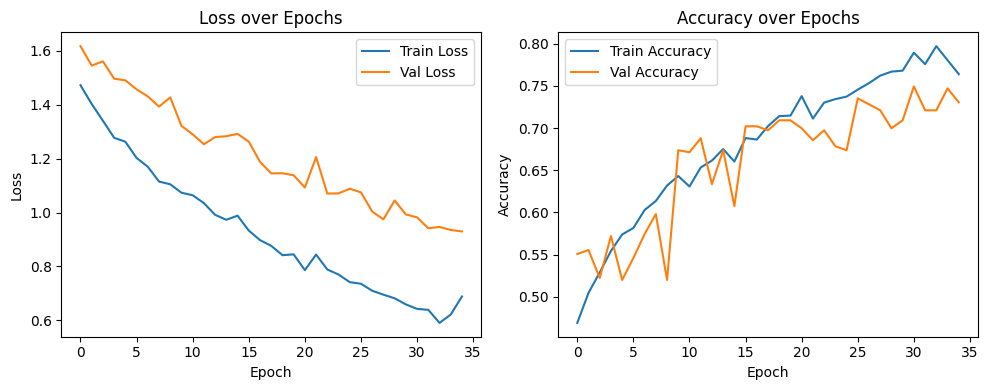

In [12]:
history = best_model.fit(train_ds, validation_data=val_ds, epochs=35)

# then later:
plt.figure(figsize=(10, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# metrics
y_true = np.concatenate([y for x, y in test_ds], axis = 0)
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print(classification_report(y_true, y_pred))


17/17 [==============================] - 1s 60ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       110
           1       0.84      0.74      0.79        50
           2       0.36      0.14      0.20        29
           3       0.83      0.34      0.48        59
           4       0.76      0.91      0.83        88
           5       0.74      0.70      0.72        57
           6       0.60      0.34      0.43        44
           7       0.51      0.88      0.65        92

    accuracy                           0.72       529
   macro avg       0.70      0.62      0.63       529
weighted avg       0.74      0.72      0.70       529



W0000 00:00:1759981799.032059  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.032616  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.032930  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.033610  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.034179  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.034666  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.035347  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.036941  810002 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1759981799.037726  810002 gp